# 1. Przygotowanie środowiska

In [1]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/
Mounted at /content/gdrive
'Biwak miejsca.gmap'   data_for_train	       'Google Earth'   Passwords.kdbx
'Colab Notebooks'     'Forgotten places.gmap'  'My Drive'


In [2]:
!cp /mydrive/data_for_train/coins/obj.zip ./

In [3]:
!unzip ../obj.zip -d content/
%cd content/

Archive:  ../obj.zip
   creating: content/obj/
  inflating: content/obj/20201211_200236.txt  
  inflating: content/obj/classes.txt  
  inflating: content/obj/IMG_20201211_190633.jpg  
  inflating: content/obj/IMG_20201211_190633.txt  
  inflating: content/obj/IMG_20201211_190708.jpg  
  inflating: content/obj/IMG_20201211_190708.txt  
  inflating: content/obj/IMG_20201211_190736.jpg  
  inflating: content/obj/IMG_20201211_190736.txt  
  inflating: content/obj/IMG_20201211_190810.jpg  
  inflating: content/obj/IMG_20201211_190810.txt  
  inflating: content/obj/IMG_20201211_191547.jpg  
  inflating: content/obj/IMG_20201211_191547.txt  
  inflating: content/obj/IMG_20201211_191710.jpg  
  inflating: content/obj/IMG_20201211_191710.txt  
  inflating: content/obj/IMG_20201211_191729.jpg  
  inflating: content/obj/IMG_20201211_191729.txt  
  inflating: content/obj/IMG_20201211_191816.jpg  
  inflating: content/obj/IMG_20201211_191816.txt  
  inflating: content/obj/IMG_20201211_191835.jpg  


In [4]:
import glob
import random

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline

# 2. Załadowanie YOLOv3
Wcześniej wytrenowany model należy przekonwertować do postaci w TensorFlow, aby można było wywoływać predykcje z poziomu Pythona. Do tego celu wykorzystano gotowy kod pod adresem jak poniżej.

In [6]:
!git clone https://github.com/theAIGuysCode/Object-Detection-API.git
!mv ./Object-Detection-API/yolov3_tf2/ ./
!rm -R Object-Detection-API/

Cloning into 'Object-Detection-API'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 219 (delta 5), reused 1 (delta 0), pack-reused 204
Receiving objects: 100% (219/219), 26.03 MiB | 39.32 MiB/s, done.
Resolving deltas: 100% (96/96), done.


In [7]:
from absl import app, flags, logging
from absl.flags import FLAGS
import numpy as np
from yolov3_tf2.models import YoloV3, YoloV3Tiny
from yolov3_tf2.utils import load_darknet_weights

In [8]:
def convertWeights():
    yolo = YoloV3(classes=1)
    yolo.summary()
    logging.info('model created')

    load_darknet_weights(yolo, "/mydrive/data_for_train/backup/yolov3_custom_final.weights", False)
    logging.info('weights loaded')

    img = np.random.random((1, 320, 320, 3)).astype(np.float32)
    output = yolo(img)
    logging.info('sanity check passed')

    yolo.save_weights("./weights/yolov3.tf")
    logging.info('weights saved')

convertWeights()

Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None, None,  0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, None, None, 5 11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, None, None, 2 2957312     yolo_conv_0[0][0]                
                                                                 yolo_darknet[0][1]          

Mając już przekonwertowane wagi, należy napisać funkcje która na wejście będzie brała zdjęcie, a zwracać będzie bounding boxes. Poniższy kod również jest lekko przerobioną wersją kodu dostępnego w linku powyżej.

In [9]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import (
    YoloV3, YoloV3Tiny
)
from yolov3_tf2.dataset import transform_images, load_tfrecord_dataset
from yolov3_tf2.utils import draw_outputs

In [10]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

yolo = YoloV3(classes=1)
yolo.load_weights("./weights/yolov3.tf").expect_partial()
class_names = [c.strip() for c in open("/mydrive/data_for_train/coins/obj.names").readlines()]

In [11]:
def getBoundingBoxes(img, yolo):
  img = tf.expand_dims(img, 0)
  img = transform_images(img, 416)
  t1 = time.time()
  boxes, scores, classes, nums = yolo(img)
  t2 = time.time()
  logging.info('time: {}'.format(t2 - t1))
  boxes, scores, classes, nums = yolo(img)
  return boxes.numpy()[0,:nums.numpy()[0],:], scores.numpy()[0,:nums.numpy()[0]], nums.numpy()[0]

# 4. Unet
Import tej sieci jest o wiele mniej skomplikowany, ponieważ była ona trenowania w środowisku TensorFlow.

In [12]:
unetModel = tf.keras.models.load_model('/mydrive/data_for_train/coins/u_net')

Poniższa funkcja pozwala na konwersje położeń bounding boxów z relatywnej do zdjęcia, na położenia w pixelach. Dwie kolejne funkcje służą do preparowania danych.

In [13]:
def getPixelBoundingBoxes(boxes, width, height):
  pix_boxes = []
  for box in boxes:
    x1, x2, y1, y2 = box
    p1_x = int(x1*width)
    p2_x = int(y1*width)
    p1_y = int(x2*height)
    p2_y = int(y2*height)
    pix_boxes.append([p1_x, p1_y, p2_x, p2_y])
  return pix_boxes

def inputPrepare(img_x):
  img_x = cv2.resize(img_x, (128, 128))
  return img_x/255

def createMask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0,:,:,0]

In [14]:
def takeMask(img, pix_boxes):
  img_clear = np.zeros_like(img[:,:,0])
  for pix_box in pix_boxes:
    temp_img = img[pix_box[1]:pix_box[3], pix_box[0]:pix_box[2], :]
    w, h, _ = temp_img.shape
    temp_img = inputPrepare(temp_img)
    temp_img = temp_img.reshape(1, temp_img.shape[0], temp_img.shape[1], temp_img.shape[2])
    temp_img = unetModel.predict(temp_img)
    temp_img = createMask(temp_img)
    temp_img = cv2.resize(np.float32(temp_img), (h, w))
    temp = np.zeros_like(img[:,:,0])
    temp[pix_box[1]:pix_box[3], pix_box[0]:pix_box[2]] = temp_img
    img_clear = cv2.bitwise_or(img_clear, temp)
  return img_clear

# 5. Operacje na obrazach

In [15]:
images_path_list = glob.glob("./obj/*.jpg")

Załadowanie zdjęcia testowego

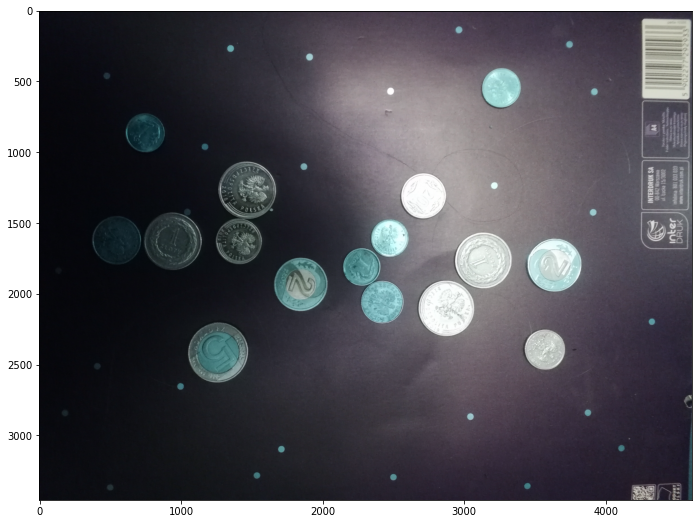

In [16]:
#image_path = random.choice(images_path_list)
image_path = "./obj/IMG_20201211_190810.jpg"
img = cv2.imread(image_path)
plt.figure(figsize=(16,9))
plt.imshow(img)

In [17]:
boxes, scores, nums = getBoundingBoxes(img, yolo)
print(nums)

16


Wyświetlenie wykrytych, przez YOLOv3, obszarów z monetami

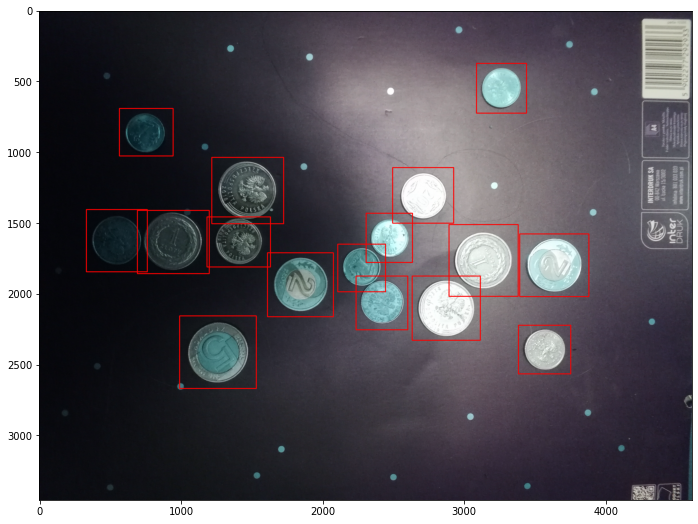

In [18]:
height, width, _ = img.shape
pix_boxes = getPixelBoundingBoxes(boxes, width, height)

img_rectangles = img.copy()
for pix_box in pix_boxes:
  cv2.rectangle(img_rectangles, (pix_box[0], pix_box[1]), (pix_box[2], pix_box[3]), (255,0,0), 5)
  
plt.figure(figsize=(16,9))
plt.imshow(img_rectangles)

Wcześniej wykryte obszary zostały podane na uNet aby określić, który pixel należy do monety, a który nie.

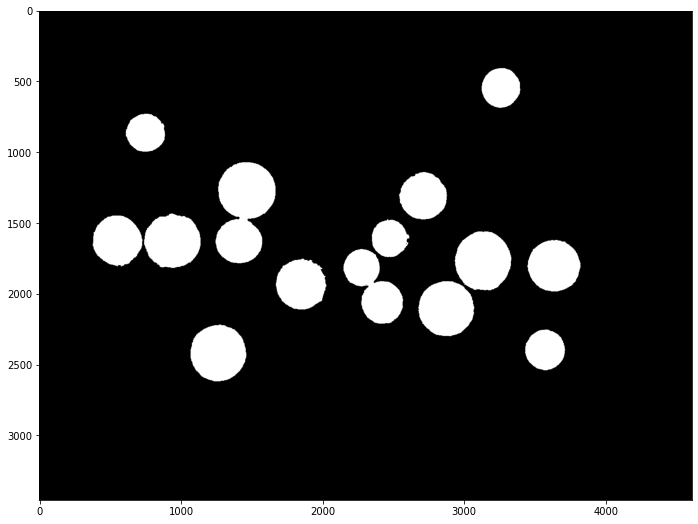

In [19]:
img_mask = takeMask(img, pix_boxes)
plt.figure(figsize=(16,9))
plt.imshow(img_mask, cmap="gray")

Usówanie zakłóceń, za pomocą otwarcia i zamknięcia.

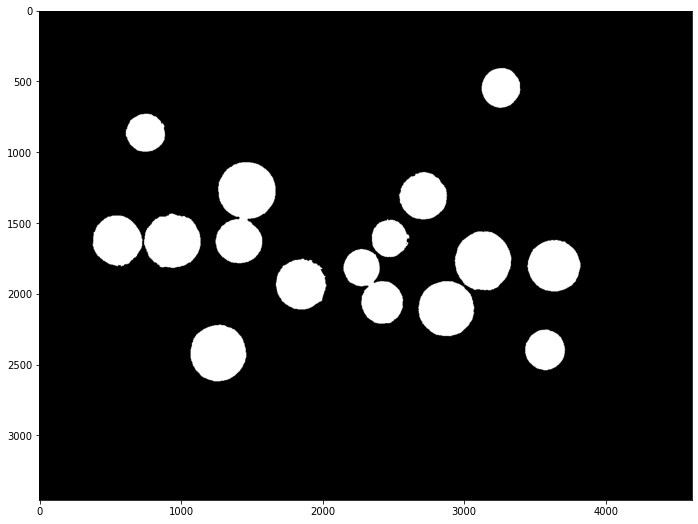

In [20]:
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(img_mask, cv2.MORPH_OPEN, kernel, iterations=5)
closing = cv2.morphologyEx(img_mask, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.figure(figsize=(16,9))
plt.imshow(closing, cmap="gray")

Liczenie obrazu z transformacją odległości

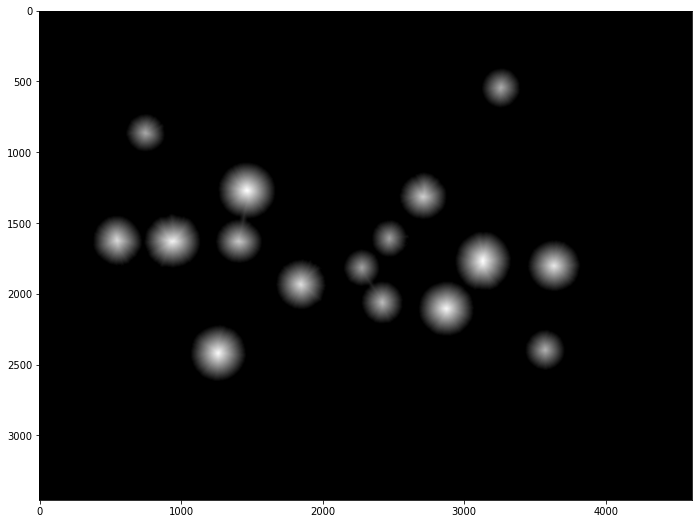

In [21]:
dist_transform = cv2.distanceTransform(closing, cv2.DIST_L2, 5)
plt.figure(figsize=(16,9))
plt.imshow(dist_transform, cmap="gray")

Podanie obrazu transformacji odelgłości na threshold, aby uzyskać ziarno

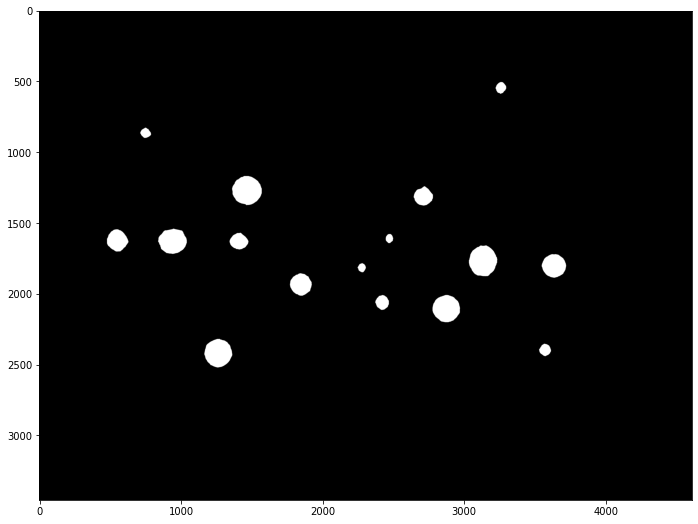

In [22]:
ret, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
plt.figure(figsize=(16,9))
plt.imshow(sure_fg, cmap="gray")

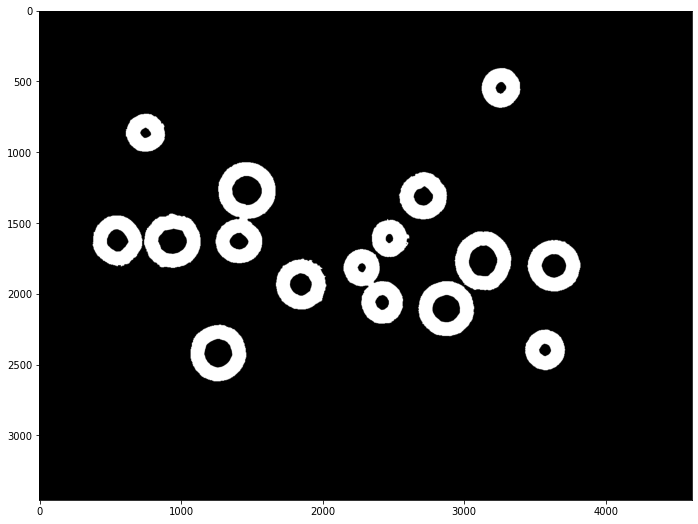

In [23]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(closing, sure_fg)
plt.figure(figsize=(16,9))
plt.imshow(unknown, cmap="gray")

Nadanie poszczególnym ziarną unikalnej wartości

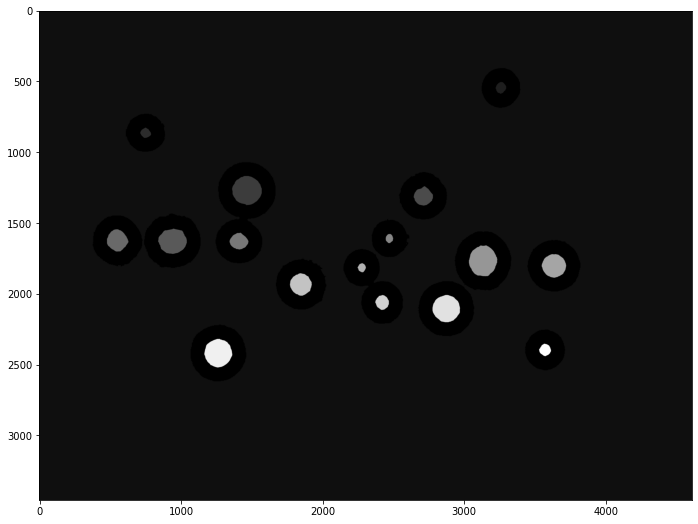

In [24]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==1] = 0
plt.figure(figsize=(16,9))
plt.imshow(markers, cmap="gray")

Preparowanie danych wejściowych dla algorytmu watershed

In [25]:
watershed_prepare = np.zeros_like(img)
watershed_prepare[:,:,0] = closing*255
watershed_prepare[:,:,1] = closing*255
watershed_prepare[:,:,2] = closing*255

Rezultat segmentacji za pomocą watershed

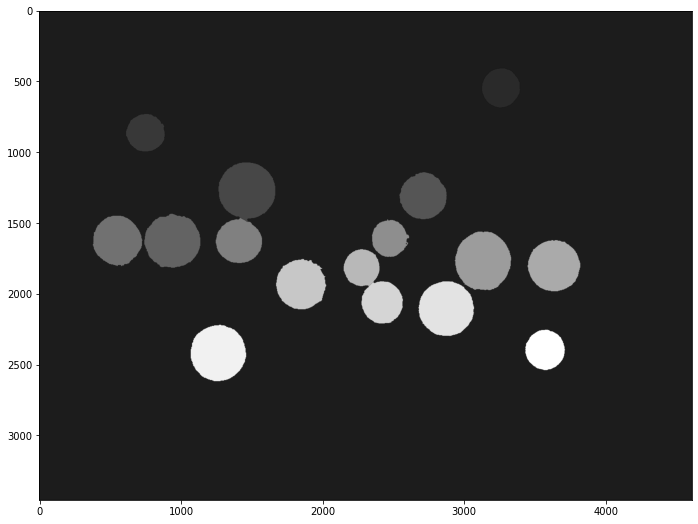

In [26]:
markers = cv2.watershed(watershed_prepare, markers)
plt.figure(figsize=(16,9))
plt.imshow(markers, cmap="gray")

Stworzenie listy z poszczególnymi maskami dla poszczególnych monet

In [28]:
segmented_markers = []
for i in range(markers.max()-1):
  temp = np.zeros_like(markers)
  temp[markers == i+2] = 255
  segmented_markers.append(temp)

Liczenie pól powierzchni zajmowanych przez monety

In [29]:
radius_markers = []
for i in segmented_markers:
  temp_surface = float(cv2.countNonZero(i))
  temp_radius = math.sqrt(temp_surface/np.pi)
  radius_markers.append(temp_radius)
  print(temp_radius)

136.2841951908738
134.2214015287577
200.97902782893664
164.03854589221683
193.04602183090867
172.9882915688531
158.37656815693694
128.089674733982
202.0113874223597
181.85380288865264
128.15302796911465
175.5336966872878
147.49754503381928
193.92616667937392
196.348512815662
139.53515975625615


Sortowanie danych

In [30]:
sort_indexes = [i[0] for i in sorted(enumerate(radius_markers), key=lambda x:x[1])]

In [31]:
def sortListByIndex(indexes, items):
  temp = []
  for i in indexes:
    temp.append(items[i])
  return temp

In [32]:
sorted_radius_markers = sortListByIndex(sort_indexes, radius_markers)
sorted_segmented_markers = sortListByIndex(sort_indexes, segmented_markers)

# Działania na kolorach

Funkcja do liczenia wartości średniej z histogramu

In [33]:
def countMediumValueHist(hist):
  temp_sum = 0
  temp_numer_items = 0
  for i, item in enumerate(hist):
    temp_sum += i*item
    temp_numer_items += item
  return temp_sum/temp_numer_items

Funkcja do aplikowania maski na zdjęciu

In [34]:
def useMask(img, mask):
  img_b = img[:,:,0]
  img_g = img[:,:,1]
  img_r = img[:,:,2]
  img_b[mask == 0] = 0
  img_g[mask == 0] = 0
  img_r[mask == 0] = 0
  img[:,:,0] == img_b
  img[:,:,1] == img_g
  img[:,:,2] == img_r
  return img

Zbieranie danych, dla poszczególnych monet, na temat kolorów w przestrzenie RGB i HSV

In [35]:
b_markers = []
g_markers = []
r_markers = []
h_markers = []
s_markers = []
v_markers = []
for i in segmented_markers:
  temp_img = useMask(img.copy(), i)
  temp_b = cv2.calcHist([temp_img[:,:,0]], [0], None, [255], [1,255])
  temp_g = cv2.calcHist([temp_img[:,:,1]], [0], None, [255], [1,255])
  temp_r = cv2.calcHist([temp_img[:,:,2]], [0], None, [255], [1,255])
  b_markers.append(countMediumValueHist(temp_b))
  g_markers.append(countMediumValueHist(temp_g))
  r_markers.append(countMediumValueHist(temp_r))

  temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2HSV)
  temp_h = cv2.calcHist([temp_img[:,:,0]], [0], None, [179], [1,179])
  temp_s = cv2.calcHist([temp_img[:,:,1]], [0], None, [255], [1,255])
  temp_v = cv2.calcHist([temp_img[:,:,2]], [0], None, [255], [1,255])
  h_markers.append(countMediumValueHist(temp_h))
  s_markers.append(countMediumValueHist(temp_s))
  v_markers.append(countMediumValueHist(temp_v))

Średnie wartości kanałów RGB dla posortowanych monet. Oś x pokazuje index posortowanej monety (od najmniejszej co do powierzchni do największej)

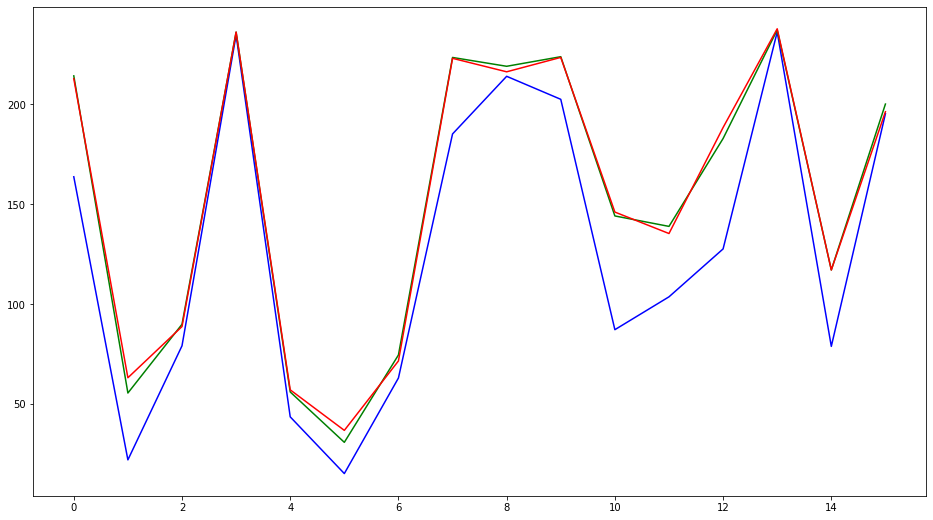

In [36]:
plt.figure(figsize=(16,9))
plt.plot(b_markers, 'b')
plt.plot(g_markers, 'g')
plt.plot(r_markers, 'r')

Średnie wartości kanałów HSV.

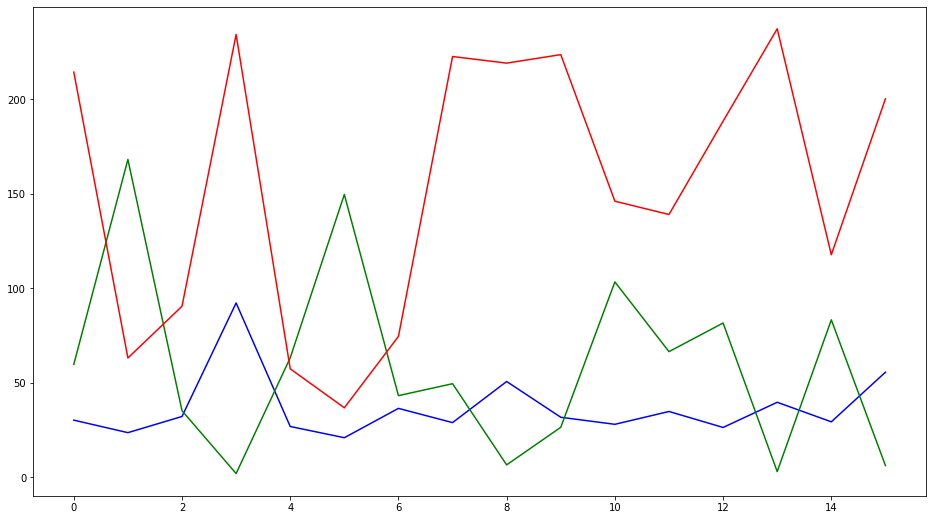

In [37]:
plt.figure(figsize=(16,9))
plt.plot(h_markers, 'b')
plt.plot(s_markers, 'g')
plt.plot(v_markers, 'r')